## Totale N.
### Esercizio 3 punto 1
Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
import pygraphviz as pygv
import os
from IPython.display import SVG, display
import math
import itertools

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class args:
    filename = "graph.gml"
    scale = 40
    figsize = 5,5

In [4]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [5]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()
    
def DrawSolFlow (G,x,f):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos,  
                           node_shape='o', 
                           node_size=600,
                           node_color='r', 
                           label=[G.nodes()])
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           nodelist = [root], 
                           node_shape='o',
                           node_size=600,
                           node_color='k', 
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w')
    
    for h,k in G.edges():
        
        flow = abs(f[h,k].x - f[k,h].x)
        
        

        G[h][k]['capacity'] = x[h,k].x
        if x[h,k].x > 0.00001:
            if x[h,k].x > 0.999999:
                nx.draw_networkx_edges(G, 
                                       pos=pos, 
                                       edgelist=[(h,k)],
                                       edge_color='k')
                
                nx.draw_networkx_edge_labels(G, 
                                             pos=pos,
                                             edge_labels={(h,k):'{:.2f}'.format(flow)})
            else:
                nx.draw_networkx_edges(G, 
                                       pos=pos, 
                                       edgelist=[(h,k)],
                                       edge_color='r')

    plt.axis('off')
    plt.show()

In [6]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


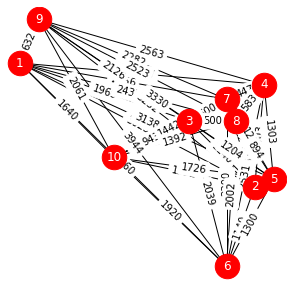

In [7]:
DrawInitG(G, withedges=True)

## Single commodity flow formulation

$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 

$$
f_{ij} = \{\text{flow carried by the arc} (i,j)\}
$$

\begin{alignat}{3}
\min cx &&\\
\sum_{e \in E} x_e = n - 1 && \\
\sum_{j \in \delta^+(0)} f_{0j} - \sum_{j \in \delta^-(0)} f_{j0} = n - 1 &&\\
\sum_{j \in \delta^-(v)} f_{jv} - \sum_{j \in \delta^+(v)} f_{vj} = 1 &&\;\; \forall v \in V, v \not = \{0\} \\
f_{ij} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f_{ji} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f \ge 0, \; x_e \in \{0,1\}
\end{alignat}

In [8]:
G = nx.convert_node_labels_to_integers(G, first_label=0,label_attribute='old' )

In [9]:
G.nodes(data=True)

NodeDataView({0: {'y': 33, 'x': 1, 'old': 1}, 1: {'y': 16, 'x': 26, 'old': 2}, 2: {'y': 25, 'x': 19, 'old': 3}, 3: {'y': 30, 'x': 27, 'old': 4}, 4: {'y': 17, 'x': 28, 'old': 5}, 5: {'y': 5, 'x': 23, 'old': 6}, 6: {'y': 28, 'x': 23, 'old': 7}, 7: {'y': 25, 'x': 24, 'old': 8}, 8: {'y': 39, 'x': 3, 'old': 9}, 9: {'y': 20, 'x': 11, 'old': 10}})

### Solution computed by standard algorithm

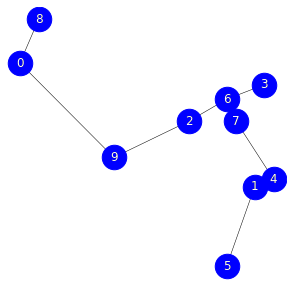

In [10]:
T = nx.minimum_spanning_tree(G, weight='cost')

plt.figure(figsize=args.figsize)


pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

nx.draw_networkx(T, 
                 pos=pos, 
                 width=0.5, 
                 node_shape='o', 
                 node_size=600,
                 node_color='blue')

nx.draw_networkx_labels(T, pos=pos, font_color='w', font_size=12);

  
plt.axis('off')
plt.show()

## Solution by combinatorial algorithm

In [17]:
# Define the root node
root = 0

# Define a Directed Graph by doubling the edges of G
D = G.to_directed()

mstflow = gb.Model()

x = mstflow.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()],
                    ub = 1.0,
                    vtype=gb.GRB.BINARY,
                    name='x')

f = mstflow.addVars(D.edges(), ub=G.number_of_nodes(), vtype=gb.GRB.CONTINUOUS, name='f')


# Cardinality constraint
mstflow.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')


# Flow at root costraint
mstflow.addConstr(f.sum(root, '*') - f.sum('*', root) == G.number_of_nodes() - 1, \
                  'Flow_at_root')


# Balance constraint for each node
for v in G.nodes():
    if v != root:
        name = 'Balance_' + str(v)
        mstflow.addConstr(f.sum('*',v) - f.sum(v,'*') == 1, name=name)
        
        
# Constraints on flow
for e in G.edges():    
    h = e[0]
    k = e[1]
        
    name = "Force_f(%d,%d)_x(%d,%d)" % (h, k, e[0], e[1])
    mstflow.addConstr(f[h,k] <= (G.number_of_nodes() - 1) * x[e], name=name)

    name = "Force_f(%d,%d)_x(%d,%d)" % (k, h, e[0], e[1])
    mstflow.addConstr(f[k,h] <= (G.number_of_nodes() - 1) * x[e], name=name)

mstflow.update()
mstflow.write('mstflow.lp')

In [12]:
mstflow.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 101 rows, 135 columns and 405 nonzeros
Model fingerprint: 0x6d097c73
Variable types: 90 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 14550.000000
Presolve time: 0.00s
Presolved: 101 rows, 135 columns, 405 nonzeros
Variable types: 90 continuous, 45 integer (45 binary)

Root relaxation: objective 5.746667e+03, 57 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5746.66667    0    5 14550.0000 5746.66667  60.5%     -    0s
H    0     0                    7002.0000000 5746.66667  17.9%     -    0s
     0     0 6507.0

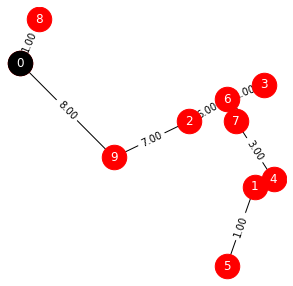

In [13]:
DrawSolFlow(G, x, f)

## Degree constrained spanning tree

$$ \sum_{e \in \delta(0)} x_e \le \Delta$$ 

In [14]:
# Root degree constraint
rootdeg = 1
mstflow.addConstr(gb.quicksum([x[e] for e in G.edges(root)]), \
                  sense='<=', rhs=rootdeg, name='RootDegree')

mstflow.update()
mstflow.write('mst_deg.lp')

In [15]:
mstflow.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 102 rows, 135 columns and 414 nonzeros
Model fingerprint: 0x65b0fd66
Variable types: 90 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint RootDegree by 1.000000000

Found heuristic solution: objective 14550.000000
Presolve removed 19 rows and 18 columns
Presolve time: 0.00s
Presolved: 83 rows, 117 columns, 342 nonzeros
Variable types: 72 continuous, 45 integer (45 binary)

Root relaxation: objective 5.953444e+03, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

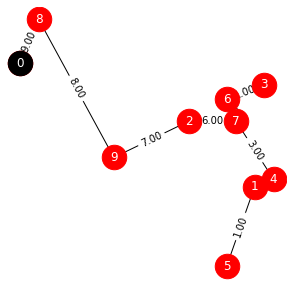

In [16]:
DrawSolFlow(G, x, f)

## Capacitated spanning tree

In [18]:
# Set an upperbound at each flow
subtreecap = 3
for i in f:
    f[i].ub = subtreecap

mstflow.update()
mstflow.write('mst_deg.lp')

In [19]:
mstflow.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 101 rows, 135 columns and 405 nonzeros
Model fingerprint: 0xed7927a1
Variable types: 90 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 9e+00]
Presolve time: 0.00s
Presolved: 101 rows, 135 columns, 405 nonzeros
Variable types: 90 continuous, 45 integer (45 binary)
Found heuristic solution: objective 21270.000000

Root relaxation: objective 8.693333e+03, 69 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 8693.33333    0    6 21270.0000 8693.33333  59.1%     -    0s
H    0     0                    13510.000000 8693.33333  35.7%     -    0s
     0     0 9249.6

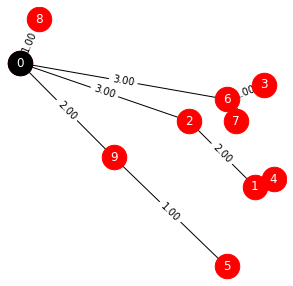

In [20]:
DrawSolFlow(G, x, f)